I'm gonna overwrite a lot of this notebook's old content. I changed the way I'm calculating wt, and wanna test that my training worked. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pearce.emulator import OriginalRecipe, ExtraCrispy
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [3]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [4]:
training_file = '/u/ki/swmclau2/des/wt_trainer/PearceRedMagicChinchillaWT.hdf5'

em_method = 'gp'
split_method = 'random'

In [5]:
a = 0.81120
z = 1.0/a - 1.0


In [6]:
fixed_params = {'z':z}#, 'r':0.18477483}

In [7]:
import h5py
f = h5py.File(training_file, 'r')
f['cosmo_no_00'].keys()

[u'a_0.548', u'a_0.593', u'a_0.658', u'a_0.712', u'a_0.811']

In [8]:
emu = OriginalRecipe(training_file, method = em_method, fixed_params=fixed_params, independent_variable=None,\
                     downsample_factor = 1.0)

In [9]:
#wt, fixed z
v = np.array([  0.00000000e+00,   3.30540588e-02,   4.93100502e-04,   3.17576810e-01,
   1.29433168e-10,   6.98880297e-03,   2.14734051e-13,
   1.66245377e+33,   5.11222704e+00,   1.23134374e+01,   1.55542754e+04,
   3.40808990e+04,   3.99014289e+04,   5.23646434e+02,   1.14408379e+13,  1.92097674e+02,   1.80096110e+01])



In [10]:
emu.x.shape

(20000, 7)

In [11]:
emu._ordered_params

OrderedDict([('logM1', (13.1, 15.1)),
             ('logMmin', (13.1, 14.1)),
             ('f_c', (0.01, 0.5)),
             ('logM0', (13.1, 16.100000000000001)),
             ('sigma_logM', (0.050000000000000003, 0.29999999999999999)),
             ('alpha', (0.80000000000000004, 1.2)),
             ('r', (-1.3802112069680488, 0.6197887586358295))])

In [12]:
print emu.y

[ 1.10300751  0.62989116  0.62433729 ..., -1.96292141 -2.16279857
 -3.45780268]


In [13]:
params = {}
#params['mean_occupation_centrals_assembias_param1'] = 0
#params['mean_occupation_satellites_assembias_param1'] = 0
params['logMmin'] = 13.2
params['sigma_logM'] = 0.2
params['f_c'] = 0.25
params['alpha'] = 1.1
params['logM1'] = 14.5
params['logM0'] = 15.5
#params['z'] = 0.5
print params

{'logMmin': 13.2, 'f_c': 0.25, 'logM0': 15.5, 'logM1': 14.5, 'sigma_logM': 0.2, 'alpha': 1.1}


In [14]:
emu.x[0,:-1]

array([-1.15872252,  1.56398854,  1.19329933,  0.69454471,  0.83300155,
       -1.3249049 ])

In [15]:
emu._ordered_params.items()

[('logM1', (13.1, 15.1)),
 ('logMmin', (13.1, 14.1)),
 ('f_c', (0.01, 0.5)),
 ('logM0', (13.1, 16.100000000000001)),
 ('sigma_logM', (0.050000000000000003, 0.29999999999999999)),
 ('alpha', (0.80000000000000004, 1.2)),
 ('r', (-1.3802112069680488, 0.6197887586358295))]

In [36]:
l = len(emu.scale_bin_centers)
idx = 200
params = {pname:pval for pname, pval in zip(emu._ordered_params.iterkeys(), emu.x[idx*l,:-1]*emu._x_std[:-1] + emu._x_mean[:-1])}

In [37]:
for k,v in params.iteritems():
    print k,'\t'*5,v

logMmin 					13.1250414616
f_c 					0.120860324504
logM0 					15.1840773465
logM1 					14.2951918178
sigma_logM 					0.265703160079
alpha 					1.06746163096


In [38]:
zbin = 1
wt_redmagic = np.loadtxt('/u/ki/swmclau2/Git/pearce/bin/mcmc/buzzard2_wt_%d%d.npy'%(zbin,zbin))

In [39]:
sc_inv = 0.0001239041803415539
W = 0.00275848072207

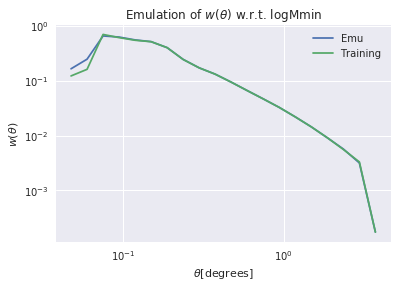

In [40]:
#param_name = 'logMmin'
#bounds = emu.get_param_bounds(param_name)
#vals = np.linspace(bounds[0], bounds[1], 4)
#for v in vals:
    #params[param_name] = v
wt = emu.emulate_wrt_r(params, emu.scale_bin_centers)[0]
plt.plot(emu.scale_bin_centers, 10**wt, label = 'Emu') #label = '%s=%.2f'%(param_name, v) )
plt.plot(emu.scale_bin_centers, 10**emu.y[(idx)*l:(idx+1)*l], label = 'Training')
#plt.plot(emu.scale_bin_centers, wt_redmagic, label = 'RedMagic')
plt.ylabel(r'$w(\theta)$')
plt.xlabel(r'$\theta \mathrm{[degrees]}$')
plt.loglog();
plt.xscale('log')
plt.legend(loc='best')
plt.title(r'Emulation of $w(\theta)$ w.r.t. %s'%param_name)

In [42]:
from sklearn.model_selection import train_test_split
x, y, yerr = emu.x, emu.y, emu.yerr
#downsample_idxs = np.random.choice(x.shape[0], size = int(x.shape[0]), replace = False)
#x,y, yerr = x[downsample_idxs, :], y[downsample_idxs], yerr[downsample_idxs]

train_x, test_x, train_y, test_y, train_yerr, test_yerr = train_test_split(x, y, yerr, test_size = 0.1)

In [43]:
model = emu._emulator
model.compute(train_x, train_yerr)

In [44]:
pred_y = model.predict(train_y, test_x, False, False, False)*emu._y_std + emu._y_mean

In [45]:
np.mean(np.abs((pred_y-test_y)/test_y))
#np.mean(np.abs((pred_y-train_y)/train_y))

0.12499526681731239

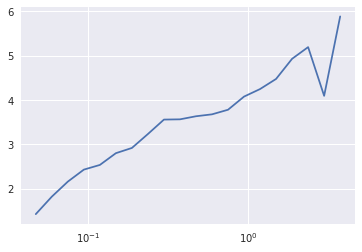

In [131]:
plt.plot(emu.scale_bin_centers, wt/wt_redmagic)
plt.xscale('log')

In [132]:
print wt

[ 0.65079685  0.65842913  0.6265125   0.56132946  0.4839495   0.42266191
  0.38234275  0.34738497  0.30874707  0.26819497  0.22849252  0.19071606
  0.15552032  0.12321993  0.09440423  0.0706618   0.05204146  0.03479707
  0.01857568  0.01568403]


In [133]:
from pearce.mocks import compute_prim_haloprop_bins, cat_dict

In [134]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[a]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(a)
#halo_masses = cat.halocat.halo_table['halo_mvir']

InvalidCacheLogEntry: 
You tried to load a cached halo catalog with the following characteristics:

simname = ``chinchilla``
halo_finder = ``rockstar``
version_name = ``Lb400-2048``
redshift = ``0.232741617357``

There is no matching catalog in cache within dz_tol = 0.05 of these inputs.
There are multiple entries in the cache log 
within dz_tol = 0.05 of your inputs. 
Try using the exact redshift and/or decreasing dz_tol.
Now printing the matching entries:

('chinchilla', 'rockstar', 'Lb400-2048', '0.2000', '/u/ki/swmclau2/des/halocats/hlist_0.83.list.chinchilla_Lb400-2048.hdf5')
('chinchilla', 'rockstar', 'Lb400-2048', '0.2327', '/u/ki/swmclau2/des/halocats/hlist_0.81.list.chinchilla_Lb400-2048.hdf5')


In [ ]:
cat.load_model(a, 'hsabRedMagic')

In [ ]:
binno = 1
binlen = len(emu.scale_bin_centers)
params = {pname:val for pname, val in zip(emu._ordered_params.iterkeys(), emu.x[binno*binlen,:-1])}
cat.populate(params)

In [ ]:
theta_bins = np.logspace(np.log10(2.5), np.log10(250), 21)/60
tpoints = (theta_bins[1:]+theta_bins[:-1])/2

In [ ]:
rbins = [0.31622777, 0.44326829, 0.62134575, 0.87096359, 1.22086225, 1.7113283, 2.39883292, 3.36253386, 4.71338954, 6.60693448, 9.26118728,  12.98175275, 18.19700859,  25.50742784,  35.75471605,  50.11872336]

In [ ]:
params['mean_occupation_centrals_assembias_param1'] = 0.0
params['mean_occupation_satellites_assembias_param1'] = 0
params['logMmin'] = 12.3
params['sigma_logM'] = 0.28
params['f_c'] = 0.2
params['alpha'] = 1.01
params['logM1'] = 13.71
params['logM0'] = 11.39

In [ ]:
redmagic_nd = np.loadtxt('/u/ki/swmclau2/Git/pearce/bin/mcmc/buzzard2_nd_11.npy')
print redmagic_nd

In [ ]:
redmagic_wt = np.loadtxt('/u/ki/swmclau2/Git/pearce/bin/mcmc/buzzard2_wt_11.npy')
print redmagic_wt

In [ ]:
cat.populate(params)
wt = cat.calc_wt(theta_bins,rbins, W= 0.00275848072207, n_cores=1)
print cat.calc_analytic_nd(params)

plt.plot(emu.scale_bin_centers,wt, label = 'wt' , color = 'b')
plt.plot(emu.scale_bin_centers, emu.emulate_wrt_r(params,emu.scale_bin_centers)[0] ,label = 'Emu')
plt.plot(emu.scale_bin_centers, wt_redmagic, label = 'RedMagic', color = 'r')
plt.legend(loc='best')
plt.loglog()
plt.show()
#plt.plot(emu.scale_bin_centers,wt)
plt.plot(emu.scale_bin_centers, wt/emu.emulate_wrt_r(params,emu.scale_bin_centers)[0])
plt.xscale('log')
plt.show()
#plt.loglog()
#plt.xlim([2.25/60, 275/60])
#plt.ylim([0.8, 4.0])

In [ ]:
fig = plt.figure(figsize=(45,14))


emulation_point = [('f_c', 0.233), ('logM0', 12.0), ('sigma_logM', 0.333),
                    ('alpha', 1.053),('logM1', 13.5), ('logMmin', 12.033)]

em_params = dict(emulation_point)

em_params.update(fixed_params)
del em_params['z']

fixed_params2 = {'mean_occupation_satellites_assembias_param1':0.0,
                'mean_occupation_centrals_assembias_param1':0.0}

for idx, (param, bounds) in enumerate(emu._ordered_params.iteritems()):
    if param == 'r':
        continue
    wt_vals = []
    new_em_params = {}
    new_em_params.update(em_params)
    new_em_params.update(fixed_params2)
    for v in np.linspace(bounds[0], bounds[1], 6):
        new_em_params[param] = v
        wt_vals.append(emu.emulate_wrt_r(new_em_params, tpoints))
    wt_vals = np.array(wt_vals)
    
    pal = sns.cubehelix_palette(wt_vals.shape[0], start=idx, rot=0.3,\
                            dark=0.0, light=.60,reverse = True)
    #sns.palplot(pal)

    sns.set_palette(pal)

    #sns.set_style("darkgrid", {"axes.facecolor": "0.85"})
    plt.subplot(5,2,idx+1)

    for color, wt, v in zip(pal, wt_vals,np.linspace(bounds[0], bounds[1], 6) ):
        plt.plot(tpoints, 1+wt[0,:], color = color, label = r'%s = %.1f'%(param,v) )
    #plt.loglog()
    plt.xscale('log')
    plt.legend(loc='best')
    plt.xlim([0.1, 4])
    plt.title(r'$w(\theta)$ variance by %s'%param)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$w(\theta)$')
plt.show()